<a href="https://colab.research.google.com/github/itayhorin/Notebooks/blob/main/EfficiencyForDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pylab inline
from scipy.stats import rv_histogram
import pandas

Populating the interactive namespace from numpy and matplotlib


In [3]:
## geometry properties
##     Z             R

## -32.5 -17.5   (15)   6.4
##  -17.5 17.5   (35)  10.7
##  17.5 37.5    (20)   6.4

In [4]:
# normalize yield probabillty according to area of each surface

In [5]:
Areas = array([15*6.4,35*10.7,20*6.4])*2*pi
probs = Areas / sum(Areas)

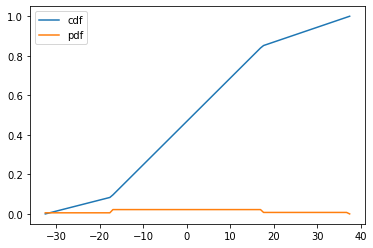

In [6]:
# creating the distribution over Z - axis
bins = array([0,15,50,70])-32.5
my_dist = rv_histogram((probs,bins))
X = linspace(bins[0],bins[-1],100)
plot(X,my_dist.cdf(X) , label = 'cdf')
plot(X,my_dist.pdf(X) , label = 'pdf')
legend()

In [18]:
n = 10000000  # number of patricles 

## creating position (from geometry) and velocity (isotropic) of each particle
z = my_dist.rvs(size = n)
theta = rand(n)*2*pi 
x = where( (-17.5<=z) &  (z<=17.5) , 10.7*cos(z) , 6.4*cos(z))
y = where( (-17.5<=z) &  (z<=17.5), 10.7*sin(z) , 6.4*sin(z))
i = rand(n)
j = rand(n)
theta_v = 2*pi*i
phi = arccos(2*j-1)
v1 = cos(theta_v)*sin(phi)
v2 = sin(theta_v)*sin(phi)
v3 = cos(phi)
P = pandas.DataFrame(data = array([x,y,z]).T ) # columns = ['x' , 'y' , 'z']
V = pandas.DataFrame(data = array([v1,v2,v3]).T )


In [19]:
# det propeties
Normal = array([0,1,0])
R = 29.6
p_plane = pandas.DataFrame(data = [[0,55.5,0]]*n )

In [20]:
## finding the time each particle reached the detector (might be negetive)
t = ( (p_plane-P).dot(Normal) )/ (V.dot(Normal))
V[0] = V[0]*t
V[1] = V[1]*t
V[2] = V[2]*t
L = P + V
L['R_xz'] = ( L[0]**2 + L[2]**2 )**0.5
L["t"] = t

In [21]:
reached_det_from_boundry = L.query("R_xz <= @R and t > 0")

In [22]:
def ReachedFrom(P):
  t = ( (p_plane-P).dot(Normal) )/ (V.dot(Normal))
  V[0] = V[0]*t
  V[1] = V[1]*t
  V[2] = V[2]*t
  L = P + V  # end position of particle
  L['R_xz'] = ( L[0]**2 + L[2]**2 )**0.5
  L["t"] = t
  RD = L.query("R_xz <= @R and t > 0")
  return RD #.shape[0]


In [23]:
def thetaOfArrival(P):
  ReachedFrom(P)
  W =  ( (ReachedFrom(P)-P)[[0,1,2]] ).dropna(how = 'all')
  WdotN = W.dot(Normal) 
  W['norm'] = (W[0]**2 + W[1]**2 + W[2]**2 )**0.5
  return  arccos(WdotN/W['norm'])


In [24]:
p_origin = pandas.DataFrame(data = [[0,0,0]]*n )

In [27]:
ratio = ReachedFrom(P).shape[0] / ReachedFrom(p_origin).shape[0] 
ratio

0.9435522109545879

9.633848558236771
21.622839072434882


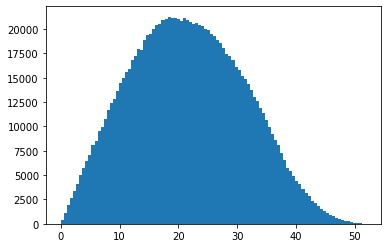

In [29]:
S1 = thetaOfArrival(P)*180/pi
hist(S1 , bins = 100);
print(S1.std())
print(S1.mean())

6.635420246121556
18.62991965562088


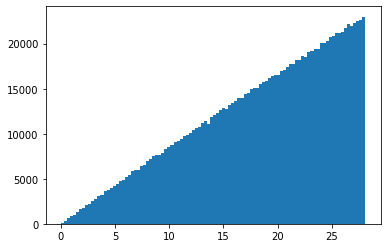

In [28]:
S2 = thetaOfArrival(p_origin)*180/pi
hist(S2 , bins = 100);
print(S2.std())
print(S2.mean())